# 4_Feature_Engineering: Shipping Cost Predictor

# Feature Engineering Process

- Encode Categorical Variables
- Convert categorical variables to numerical representations if needed
- Do buckets of each category it is necessary
- Normalize/Standardize Numerical Features
- Remove or combine that are highly correlated to prevent multicollinearity
- Apply PCA if it is suitable. In that case include the variance explainability plot

**OUTPUT**: a csv file saved in '../../data/price_predictor/processed/Sample_Product_Data_Cleaned.csv' ready for machine learning input.

In [1]:
# Imports
import os
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

### Loading Data from Data Wrangling

In [3]:
# Load variables from .env file, ignoring lines without '='
def load_env_variables(env_file='../.env'):
    # Get the current working directory
    current_dir = os.getcwd()
    env_path = os.path.join(current_dir, '..', env_file)
    
    print(f"Looking for .env file at: {env_path}")  # Debugging output

    if not os.path.exists(env_path):
        print(f".env file does not exist at: {env_path}")
        return

    with open(env_path, 'r') as file:
        for line in file:
            # Skip lines without an equals sign or comments
            if '=' in line and not line.strip().startswith('#'):
                key, value = line.strip().split('=', 1)
                os.environ[key] = value
                print(f"Loaded {key}={value}")  # Debugging output

# Load environment variables
load_env_variables()

Looking for .env file at: c:\repos\ai-logistics\notebooks\ShipCostPredictor\..\../.env
Loaded BUCKET_NAME_INBOUND=logimo-inbound
Loaded BUCKET_NAME_ALIGNED=logimo-aligned
Loaded BUCKET_NAME_OUTBOUND=logimo-outbound
Loaded PREFIX_KEY=ship_cost_predictor/


In [4]:
# Create an S3 client
s3 = boto3.client('s3')

# Specify the bucket name and prefix (folder path)
bucket_name = os.getenv('BUCKET_NAME_ALIGNED')
prefix = os.getenv('PREFIX_KEY')

# List objects in the specified S3 folder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Initialize a list to store CSV file keys
csv_files = []

# Iterate over the objects and collect keys of CSV files
for obj in response.get('Contents', []):
    object_key = obj['Key']
    if object_key.endswith('.csv'):
        csv_files.append(object_key)


# Fetch the content of the second CSV file from S3
obj = s3.get_object(Bucket=bucket_name, Key=csv_files[0])

# Read the content of the CSV file
csv_content = obj['Body'].read().decode('utf-8')

# Use pandas to read the CSV content into a DataFrame
supply_chain_df_cleaned = pd.read_csv(StringIO(csv_content))

In [5]:
supply_chain_df_cleaned

,product_type,sku,estimated_price,availability,number_of_products_sold,revenue_generated,customer_demographics,stock_levels,lead_times,order_quantities,...,production_volumes,manufacturing_lead_time,manufacturing_costs,inspection_results,defect_rates,transportation_modes,routes,costs,demurrage,demurrage_bin
0,cosmetics,062000007,22790.0,17.0,715.0,8656.12,Non-binary,58.0,24.0,79.0,...,168.0,21.0,71.42,Pending,3.35,Rail,Route_B,407.65,0.0,False
1,cosmetics,1VBA0260GE,53970.0,78.0,949.0,4516.14,Unknown,75.0,15.0,90.0,...,617.0,28.0,80.63,Pass,4.66,Rail,Route_A,424.80,1633889.0,True
2,skincare,1VBF0810GE,80180.0,44.0,687.0,6449.54,Male,97.0,20.0,10.0,...,306.0,17.0,65.34,Pending,0.61,Air,Route_B,603.41,0.0,False
3,skincare,1VMG0080GE,62870.0,46.0,903.0,1755.28,Female,18.0,21.0,98.0,...,486.0,29.0,29.09,Fail,3.09,Rail,Route_C,331.07,0.0,False
4,skincare,1VMG0140GE,83820.0,99.0,163.0,7097.87,Non-binary,88.0,18.0,50.0,...,941.0,17.0,97.18,Pending,2.58,Road,Route_B,392.25,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,haircare,CHAN020,22350.0,61.0,538.0,8806.32,Unknown,2.0,2.0,4.0,...,181.0,9.0,54.62,Pass,3.86,Air,Route_B,534.60,0.0,False
1636,cosmetics,INDI042,87360.0,41.0,719.0,4094.14,Unknown,98.0,2.0,26.0,...,299.0,1.0,53.52,Pending,0.74,Air,Route_B,681.55,2094811.0,True
1637,haircare,INDI046,89580.0,5.0,413.0,1828.60,Unknown,99.0,21.0,67.0,...,667.0,3.0,53.77,Fail,4.81,Sea,Route_B,752.71,0.0,False
1638,haircare,USLA1001,27120.0,18.0,987.0,3173.07,Male,30.0,24.0,33.0,...,524.0,24.0,13.19,Fail,2.97,Sea,Route_A,956.01,741579.0,True


In [8]:
supply_chain_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_type             1640 non-null   object 
 1   sku                      1640 non-null   object 
 2   estimated_price          1640 non-null   float64
 3   availability             1640 non-null   float64
 4   number_of_products_sold  1640 non-null   float64
 5   revenue_generated        1640 non-null   float64
 6   customer_demographics    1640 non-null   object 
 7   stock_levels             1640 non-null   float64
 8   lead_times               1640 non-null   float64
 9   order_quantities         1640 non-null   float64
 10  shipping_times           1640 non-null   float64
 11  shipping_carriers        1640 non-null   object 
 12  shipping_costs           1640 non-null   float64
 13  supplier_name            1640 non-null   object 
 14  location                

---

### Encoding Categorical Variables

In this segment, we'll encode the categorical variables to integrate them into the modeling phase of the data science process. Then, we will save a new dataframe with the categorical variables encoded.

In [3]:
# Encoding categorical variables
categorical_columns = [
    'product_type', 'customer_demographics', 'shipping_carriers', 'supplier_name',
    'location', 'inspection_results', 'transportation_modes', 'routes'
]
supply_chain_encoded_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
supply_chain_encoded_df.set_index('sku', inplace=True)

In [4]:
# Inspection of encoded df
supply_chain_encoded_df.head()

,price,availability,number_of_products_sold,revenue_generated,stock_levels,lead_times,order_quantities,shipping_times,shipping_costs,lead_time,...,location_Delhi,location_Kolkata,location_Mumbai,inspection_results_Pass,inspection_results_Pending,transportation_modes_Rail,transportation_modes_Road,transportation_modes_Sea,routes_Route_B,routes_Route_C
sku,,,,,,,,,,,,,,,,,,,,,
062000007,22.79,17.0,715.0,8656.12,58.0,24.0,79.0,7.0,4.70,16.0,...,False,True,False,False,True,True,False,False,True,False
1VBA0260GE,53.97,78.0,949.0,4516.14,75.0,15.0,90.0,7.0,8.68,3.0,...,True,False,False,True,False,True,False,False,False,False
1VBF0810GE,80.18,44.0,687.0,6449.54,97.0,20.0,10.0,7.0,6.37,13.0,...,True,False,False,False,True,False,False,False,True,False
1VMG0080GE,62.87,46.0,903.0,1755.28,18.0,21.0,98.0,8.0,2.10,20.0,...,True,False,False,False,False,True,False,False,False,True
1VMG0140GE,83.82,99.0,163.0,7097.87,88.0,18.0,50.0,2.0,6.27,23.0,...,False,False,False,False,True,False,True,False,True,False


In [5]:
# checking the number of columns and other relevant infomration
supply_chain_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1790 entries, 062000007 to CHNI013
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   price                             1790 non-null   float64
 1   availability                      1790 non-null   float64
 2   number_of_products_sold           1790 non-null   float64
 3   revenue_generated                 1790 non-null   float64
 4   stock_levels                      1790 non-null   float64
 5   lead_times                        1790 non-null   float64
 6   order_quantities                  1790 non-null   float64
 7   shipping_times                    1790 non-null   float64
 8   shipping_costs                    1790 non-null   float64
 9   lead_time                         1790 non-null   float64
 10  production_volumes                1790 non-null   float64
 11  manufacturing_lead_time           1790 non-null   float64
 12  

---

### Principal Component Analysis

In this section, due to the proliferation of columns, we'll implement PCA to streamline the dataset while retaining a significant portion of its variance. Our goal is to minimize the number of columns while preserving around 95% of the variance, a substantial threshold for our initial stage.

In [6]:
X = supply_chain_encoded_df.drop(columns=['price'])
y = supply_chain_encoded_df['price']

#### Scaling Features

In this phase, as we have a wide range of feature scales, we'll introduce feature scaling to standardize the values. By doing so, we aim to bring all features to a uniform scale, ensuring that no single feature dominates due to its magnitude. This step is crucial for maintaining the integrity of our model's predictions, enhancing its stability and performance across different features.

In [7]:
# Scale and normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

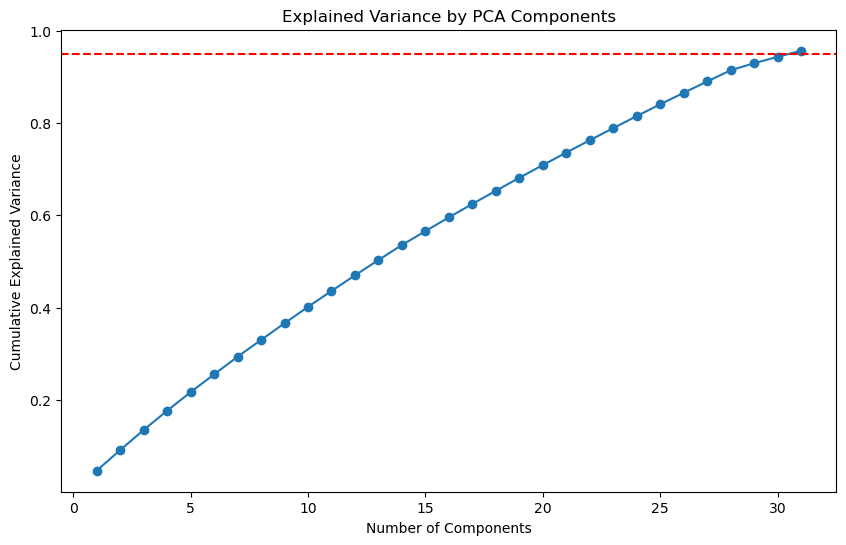

Number of components explaining at least 95.0% variance: 31


In [8]:
# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Number of components explaining at least {0.95*100}% variance: {num_components}')

In [10]:
supply_chain_X_pca_df = pd.DataFrame(X_pca)
supply_chain_y_df = pd.DataFrame(y)

supply_chain_X_pca_df.to_csv('../../data/price_predictor/processed/supply_chain_X_pca.csv', index=False)
supply_chain_y_df.to_csv('../../data/price_predictor/processed/supply_chain_Y_pca.csv', index=False)